Github link: https://github.com/genom10/Sensors2023/tree/master/HW2

# Task 2.1

## Generate noisy 1D data

### Generate _true_ data

In [28]:
import numpy as np
from numpy.random import default_rng
from scipy.interpolate import CubicSpline

dots_number = 6
dots_range = 5

rng = default_rng()
x = np.linspace(0, (dots_number-1)*dots_range, num=dots_number)
y = rng.standard_normal(dots_number)*10
spl = CubicSpline(x, y)

### Let's see what we got

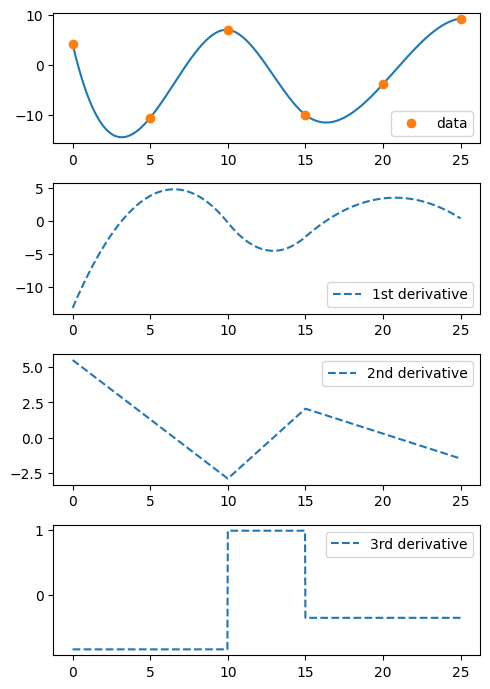

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(5, 7))
xnew = np.linspace(0, (dots_number-1)*dots_range, num=1001)
ax[0].plot(xnew, spl(xnew))
ax[0].plot(x, y, 'o', label='data')
ax[1].plot(xnew, spl(xnew, nu=1), '--', label='1st derivative')
ax[2].plot(xnew, spl(xnew, nu=2), '--', label='2nd derivative')
ax[3].plot(xnew, spl(xnew, nu=3), '--', label='3rd derivative')
for j in range(4):
    ax[j].legend(loc='best')
plt.tight_layout()
plt.show()

### Now give it some normal noize

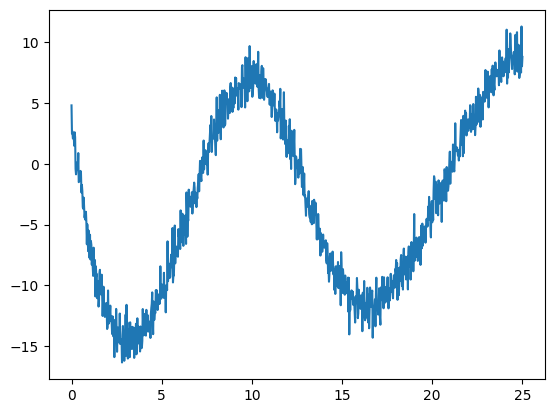

In [30]:
noize_sigma = 1

measurement = [value + rng.normal()*noize_sigma for value in spl(xnew)]
plt.plot(xnew, measurement)

## Demonstrate 1D Linear Kalman Filter estimation on data

### Create Filter

In [31]:
!pip install filterpy

In [32]:
from filterpy.kalman import KalmanFilter
import filterpy
filter = KalmanFilter(dim_x=3, dim_z=1)

dt = xnew[1] - xnew[0]


# System behaviour matrix
filter.F = np.array([[1,   dt,     (dt**2)/2],
                     [0,   1.0,    dt],
                     [0,   0,      1.0]])

# Observational matrix
filter.H = np.array([[1.0, 0.0, 0.0]])

# Noise destribution
filter.R = np.array([[noize_sigma*noize_sigma]])

# 
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt) 

# How little we trust initial estimation (larger number -> less trust)  # eOPt
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

# Initial tate                                                          # xOpt
filter.x = np.array([0.0, 0.0, 0.0]) 

### Filter generated data 

In [33]:
kalman = []
stateCovarianceHistory = []

for i in range(0, len(measurement)):
   z = [ measurement[i] ]                      # Вектор измерений
   filter.predict()                            # Этап предсказания
   filter.update(z)                            # Этап коррекции

   kalman.append(filter.x)
   stateCovarianceHistory.append(filter.P)

kalman = np.array(kalman)
stateCovarianceHistory = np.array(stateCovarianceHistory)

### Visualisation

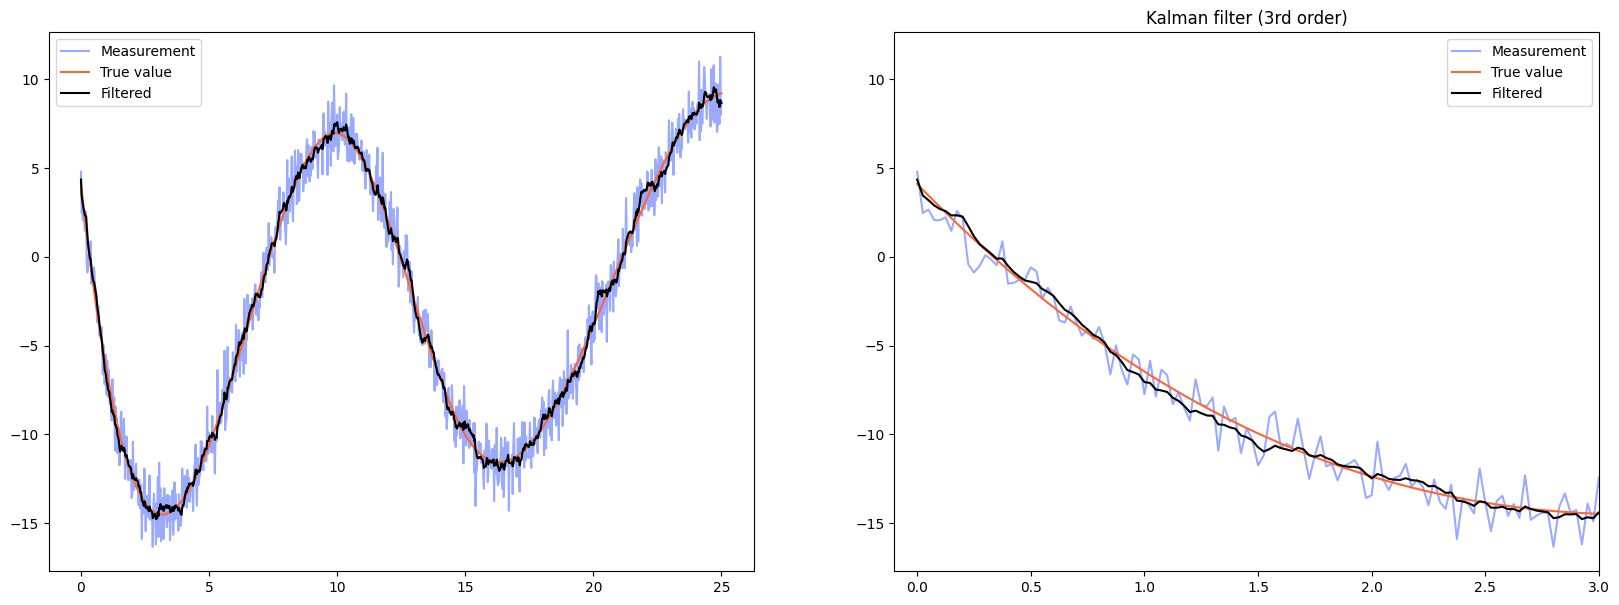

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.title("Kalman filter (3rd order)")
ax[0].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[0].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[0].plot(xnew, kalman[:, 0], label="Filtered", color="k")
ax[0].legend()

ax[1].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[1].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[1].plot(xnew, kalman[:, 0], label="Filtered", color="k")
ax[1].legend()
ax[1].set_xlim((-0.1,3))

plt.show()

## Create simplified recursive filter and compare its results with 1D Kalman filter

### Filtering data out

In [35]:
recursive = [0]
sensorTrust = 0.2
for data in measurement:
  recursive.append((recursive[-1] * (1-sensorTrust)) + (data * sensorTrust))

### Plotting

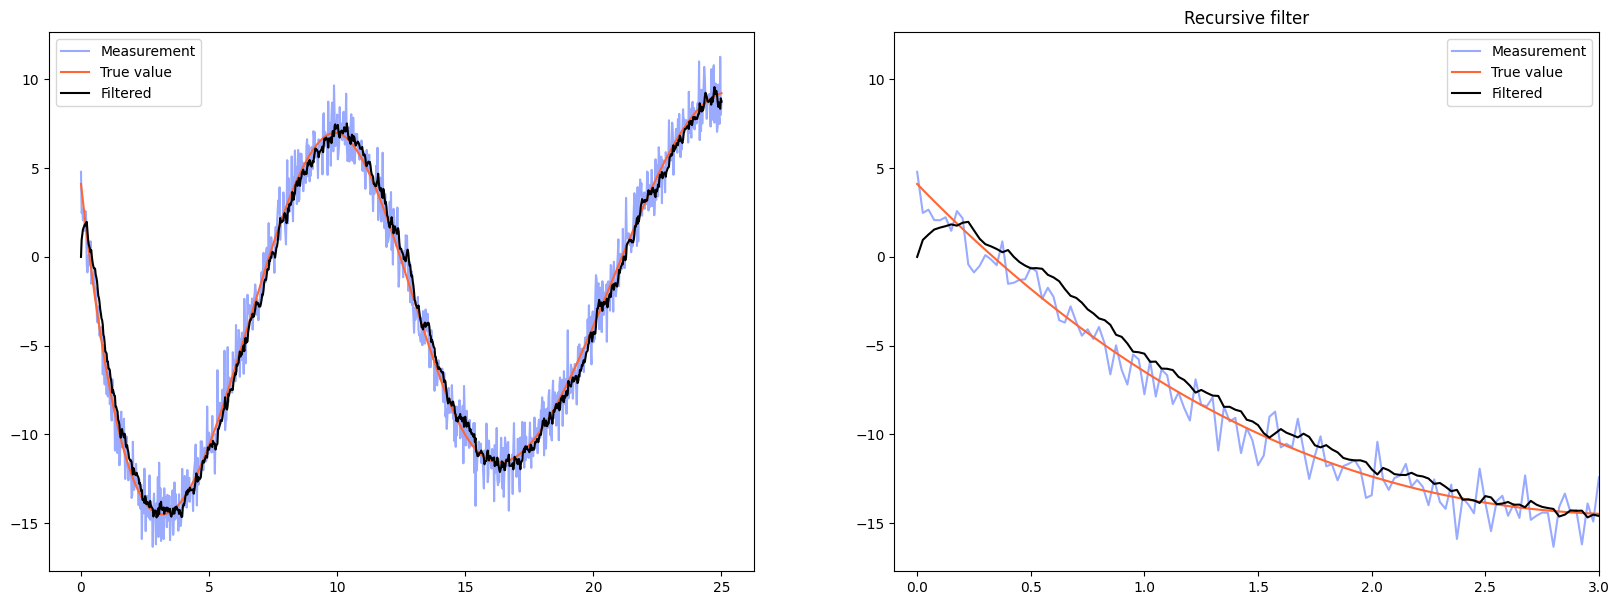

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.title("Recursive filter")
ax[0].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[0].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[0].plot(xnew, recursive[:len(xnew)], label="Filtered", color="k")
ax[0].legend()

ax[1].plot(xnew, measurement, label="Measurement", color="#99AAFF")
ax[1].plot(xnew, spl(xnew), label="True value", color="#FF6633")
ax[1].plot(xnew, recursive[:len(xnew)], label="Filtered", color="k")
ax[1].legend()
ax[1].set_xlim((-0.1,3))

plt.show()

## Compare the performance

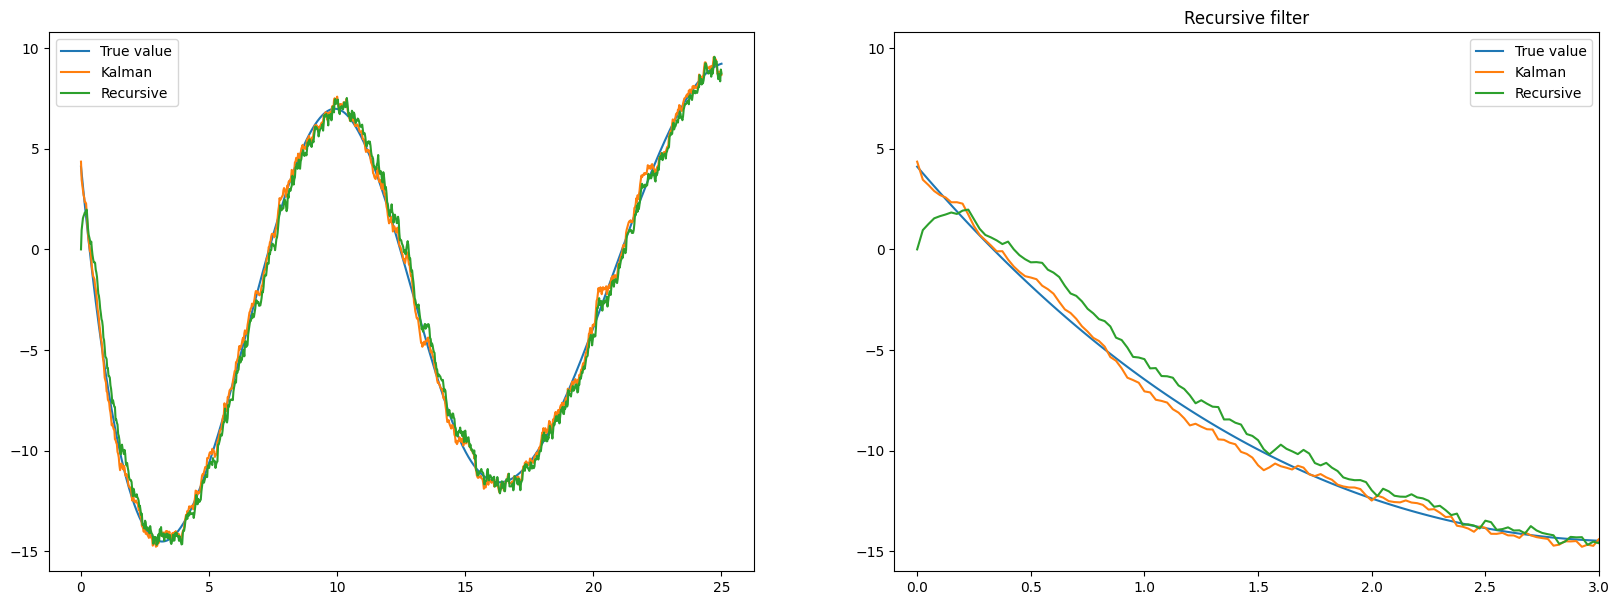

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
plt.title("Recursive filter")
ax[0].plot(xnew, spl(xnew), label="True value")
ax[0].plot(xnew, kalman[:, 0], label="Kalman")
ax[0].plot(xnew, recursive[:len(xnew)], label="Recursive")
ax[0].legend()

ax[1].plot(xnew, spl(xnew), label="True value")
ax[1].plot(xnew, kalman[:, 0], label="Kalman")
ax[1].plot(xnew, recursive[:len(xnew)], label="Recursive")
ax[1].legend()
ax[1].set_xlim((-0.1,3))

plt.show()

In [38]:
from sklearn.metrics import mean_squared_error

print('kalman MSE:', mean_squared_error(spl(xnew), kalman[:, 0]))
print('recursive MSE:', mean_squared_error(spl(xnew), recursive[:len(xnew)]))

kalman MSE: 0.1263427716889502
recursive MSE: 0.3217508855347482


# Task 2.2

## Import data

raw data can be found here: https://github.com/genom10/Sensors2023/blob/master/HW2/eight_part1.csv 

In [39]:
import pandas as pd
df = pd.read_csv('./eight_part1.csv', sep=',', dtype=float, decimal='.')
df = df[1:] #2st row has Latitude, Longtitude = 0
df

,Unnamed: 0,time,ax,ay,az,Latitude,Longitude,Speed (m/s)
1,1.0,0.091387,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
2,2.0,0.120560,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
3,3.0,0.134126,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
4,4.0,0.135304,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
5,5.0,0.144837,0.0000,0.0000,0.0000,55.753409,48.739783,0.00
...,...,...,...,...,...,...,...,...
22770,22770.0,185.997849,0.7210,-2.2604,1.0485,55.753097,48.741079,1.81
22771,22771.0,186.016178,0.7210,-2.2604,1.0485,55.753097,48.741079,1.81
22772,22772.0,186.020764,1.1592,-1.7141,-3.0830,55.753097,48.741079,1.81
22773,22773.0,186.023495,1.1592,-1.7141,-3.0830,55.753097,48.741079,1.81


In [40]:
!pip install folium

### Preview GPS path on the map

In [41]:
import folium

m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=100)

trail = folium.PolyLine(
    locations=df[['Latitude', 'Longitude']].values,
    weight=2,
    color='red'
).add_to(m)

m

### Preview raw data

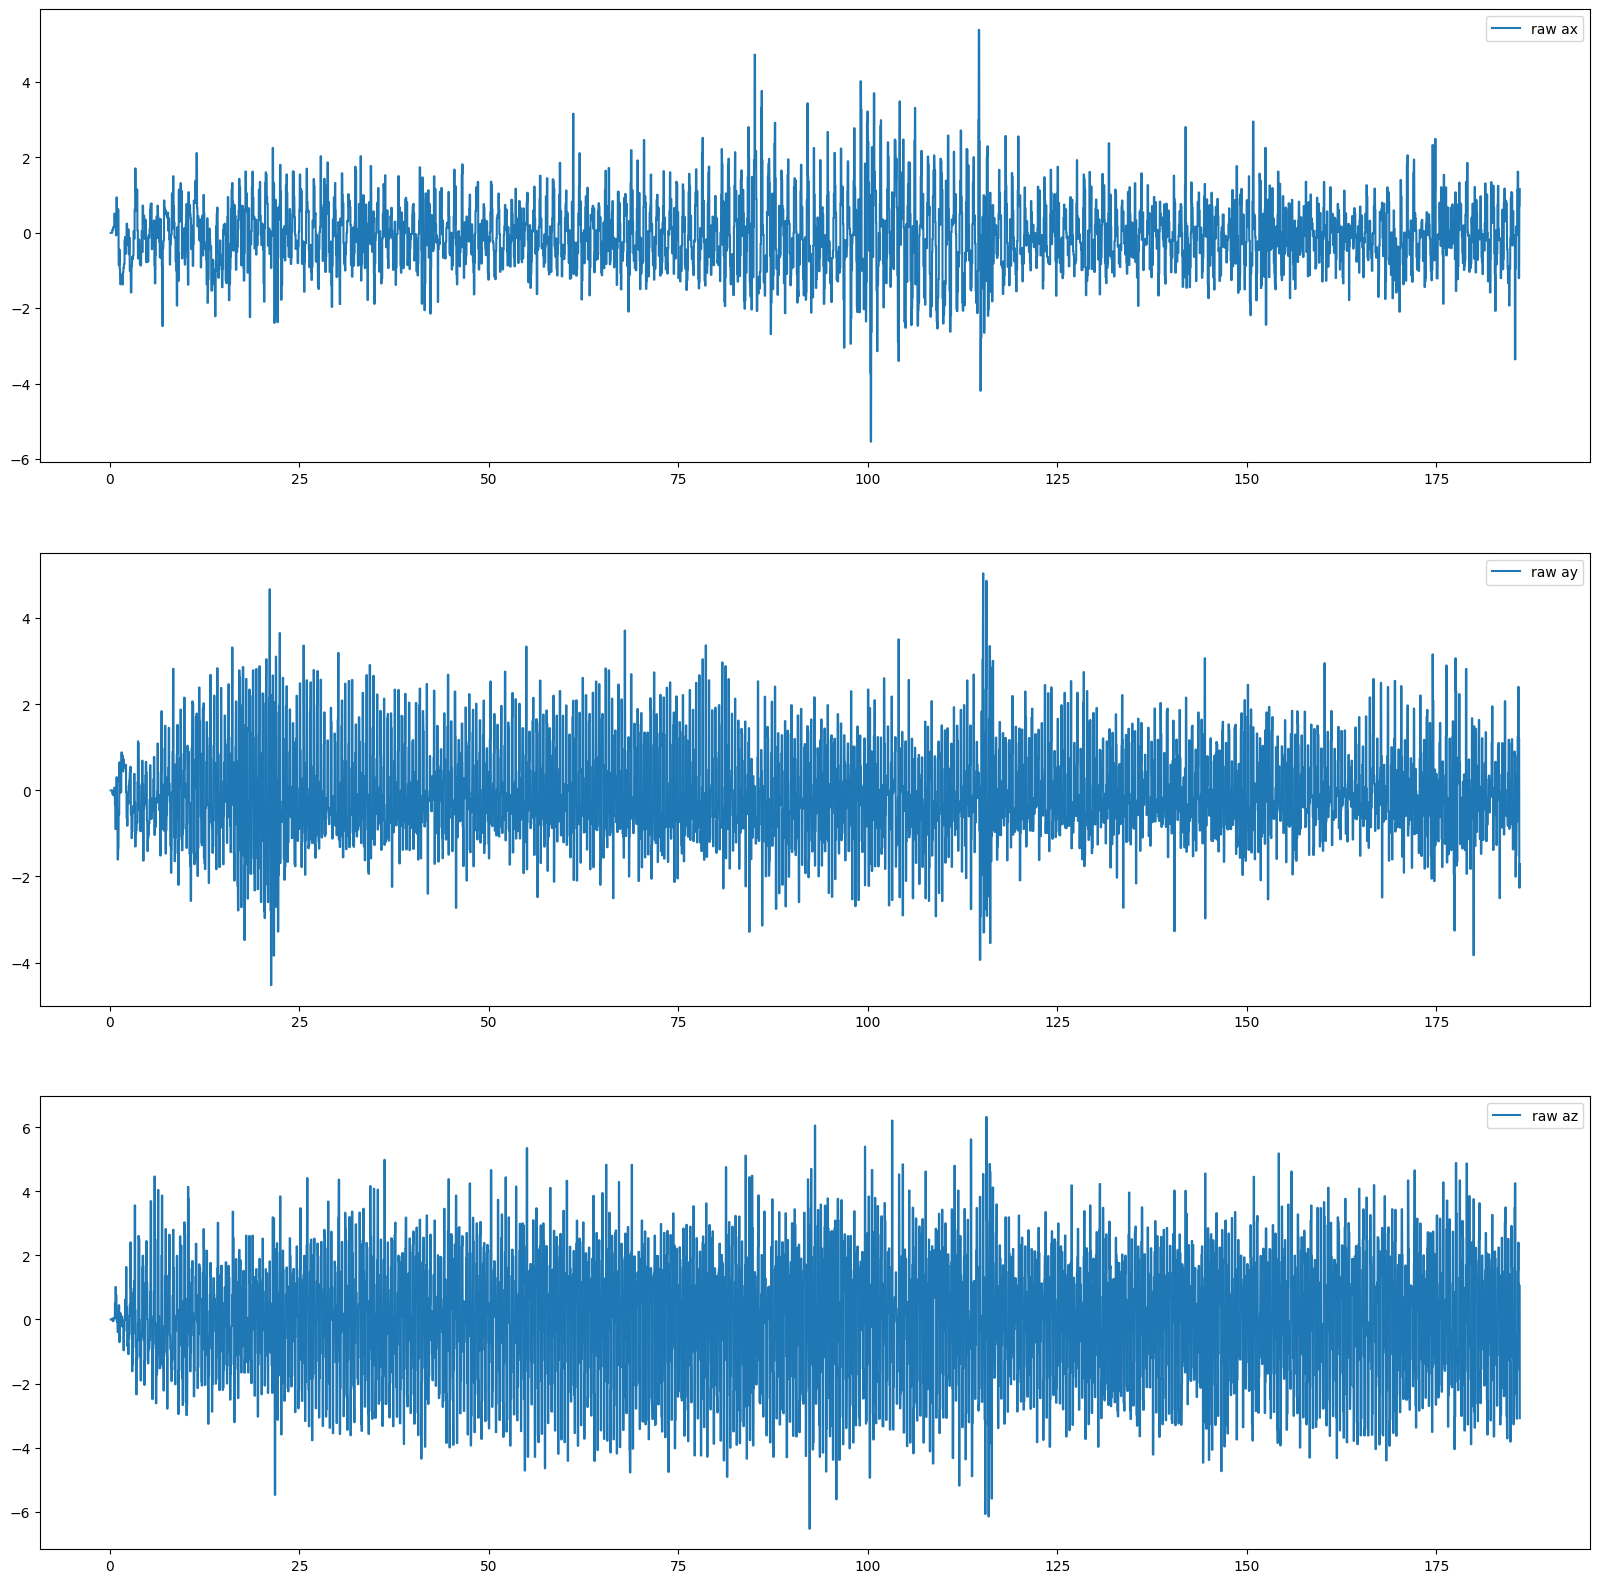

In [79]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(3, 1, figsize=(20, 20))

ax[0].plot(df['time'], df['ax'], label='raw ax')
ax[1].plot(df['time'], df['ay'], label='raw ay')
ax[2].plot(df['time'], df['az'], label='raw az')

for ax_ in ax:
    ax_.legend()

## Filter raw accelerations

Create filter

In [102]:
from filterpy.kalman import KalmanFilter
import filterpy
filter = KalmanFilter(dim_x=9, dim_z=3)

# Observational matrix
filter.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])

# Noise destribution
filter.R = np.diag([np.std(df['ax'])**2, np.std(df['ay'])**2, np.std(df['az'])**2])

# How little we trust initial estimation (larger number -> less trust)  # eOPt
filter.P = np.eye(9)*10

# Initial tate                                                          # xOpt
filter.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) 


# filter.P

lambdify `dt`-dependent parameter

In [103]:
import scipy
f = lambda dt : np.array([[1,   dt,     (dt**2)/2],
                          [0,   1.0,    dt],
                          [0,   0,      1.0]])
F = lambda dt : scipy.linalg.block_diag(*([f(dt)]*3))

q = lambda dt : filterpy.common.Q_discrete_white_noise(dim=3, dt=dt) 
Q = lambda dt : scipy.linalg.block_diag(*([q(dt)]*3))

apply Kalman filter to each measurement

In [104]:
kalman = []
stateCovarianceHistory = []

for i in range(0, len(df['ax'].values)):
   z = [ df['ax'].values[i],
         df['ay'].values[i],
         df['az'].values[i]]                         # Вектор измерений
   filter.predict(F=F(dt[i]), Q=Q(dt[i]))       # Этап предсказания Q=Q(dt[i]), 
   filter.update(z)     # Этап коррекции

   kalman.append(filter.x)
   stateCovarianceHistory.append(filter.P)

kalman = np.array(kalman)
stateCovarianceHistory = np.array(stateCovarianceHistory)

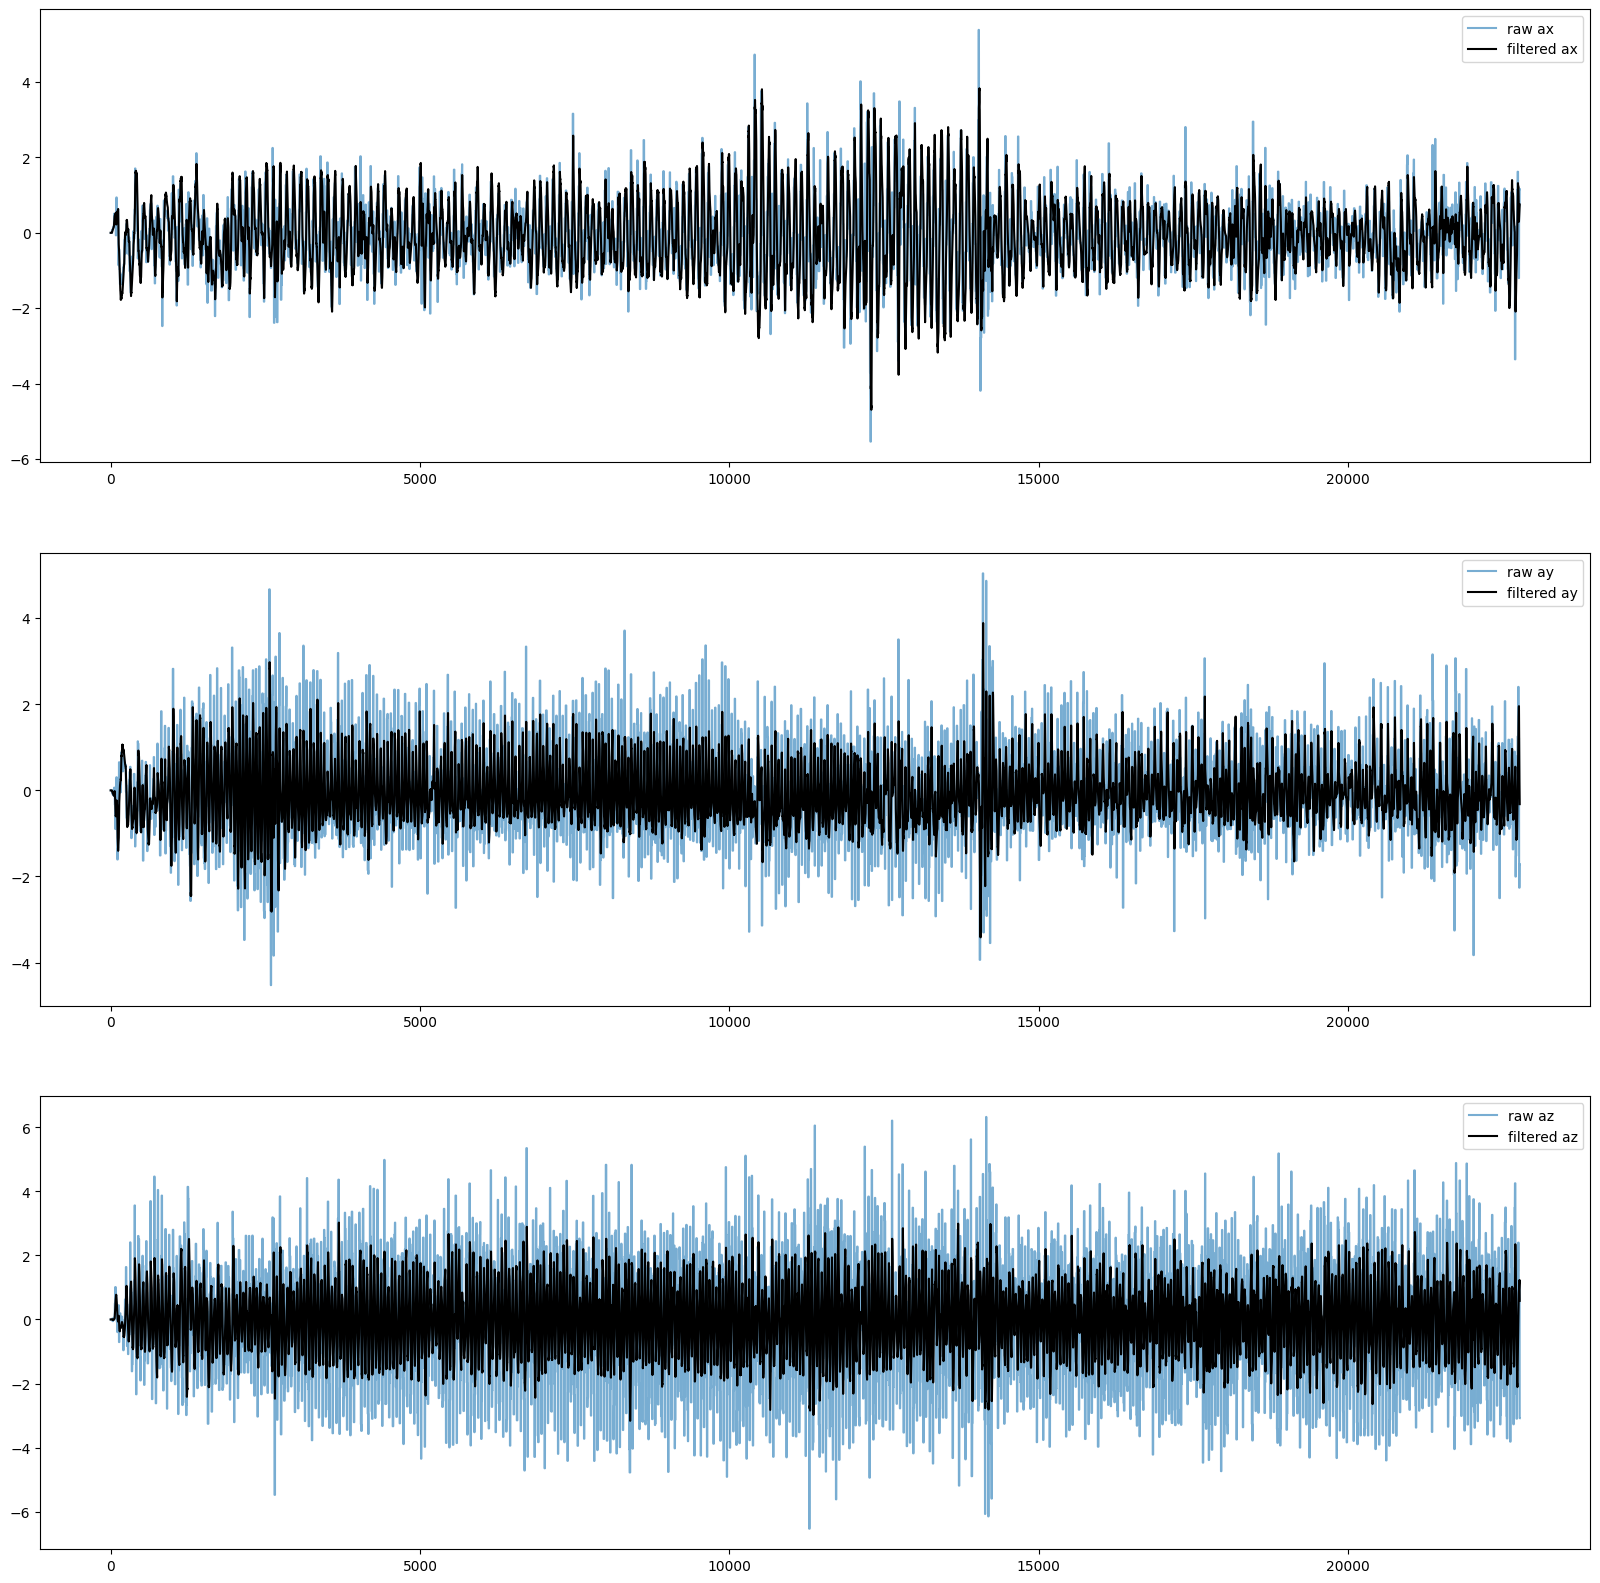

In [105]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

ax[0].plot(df['ax'], alpha=0.6, label='raw ax')
ax[1].plot(df['ay'], alpha=0.6, label='raw ay')
ax[2].plot(df['az'], alpha=0.6, label='raw az')

ax[0].plot(kalman[:,0], 'k', label='filtered ax')
ax[1].plot(kalman[:,3], 'k', label='filtered ay')
ax[2].plot(kalman[:,6], 'k', label='filtered az')

for ax_ in ax:
    ax_.legend()

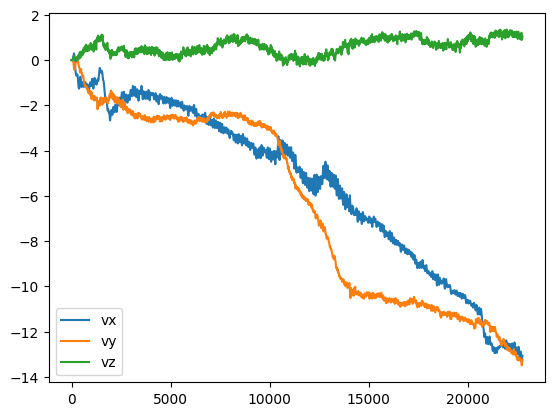

In [106]:
vx = np.cumsum(kalman[:,0] * dt, axis=0)
vy = np.cumsum(kalman[:,3] * dt, axis=0)
vz = np.cumsum(kalman[:,6] * dt, axis=0)
plt.plot(vx, label="vx")
plt.plot(vy, label="vy")
plt.plot(vz, label="vz")
plt.legend()

In [107]:
!pip install geopy

332.36399317880813


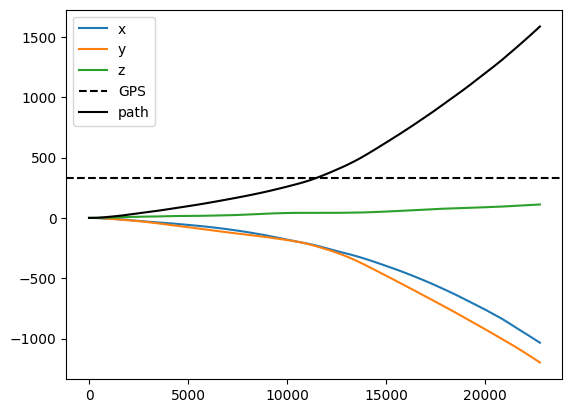

In [108]:
import geopy.distance
import numpy as np
x = np.cumsum(vx * dt, axis=0)
y = np.cumsum(vy * dt, axis=0)
z = np.cumsum(vz * dt, axis=0)
path = np.sqrt(x**2 + y**2 + z**2)

GPS = geopy.distance.geodesic(*zip(df['Latitude'].values, df['Longitude'].values)).m
print(GPS)
plt.plot(x, label="x")
plt.plot(y, label="y")
plt.plot(z, label="z")
plt.axhline(GPS, color = 'k', linestyle = '--', label="GPS") 
plt.plot(path, 'k', label="path")
plt.legend()

## Conclusion

Noise in higher-order measurements (speed, acceleration, etc.) cause great deviations in their low-order parameters (in our case length of the **path**). 

Also there are multiple stacking complications with angular velocities and accelerations. Because of that our speed spins out of control on turns. 

To avoid that we could have included calculated displacement into the Kalman filter. That would have limited deviation of displacement and henceforth velocity, improving overall accuracy of measurements.